In [3]:
import pandas as pd
import numpy as np

def load_data_from_csv(filename):
    return pd.read_csv(filename)

In [4]:
dataset = load_data_from_csv('dataset.csv')

Preprocessing: Use one hot encoding with one row per character

In [5]:
from utils import one_hot_word, generate_classification_labels
from functools import partial

max_characters = 32

possible_classes = ['m', 'f', 'n']

def preprocessing(chunk):
    characters = "abcdefghijklmnopqrstuvwxyzäöüß"
    chunk['word'] = chunk['word'].str.lower()
    chunk = chunk[chunk['word'].str.len() < max_characters]
    chunk.dropna(inplace=True)
    chunk['one_hot'] = chunk['word'].map(partial(one_hot_word, possible_characters=characters, default_length = max_characters))
    chunk['labels'] = chunk['gender'].map(partial(generate_classification_labels, classes=possible_classes))
    return chunk

dataset = preprocessing(dataset)



C:\Users\Manu\AppData\Local\Temp\ipykernel_18220\4209948579.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk.dropna(inplace=True)
C:\Users\Manu\AppData\Local\Temp\ipykernel_18220\4209948579.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['one_hot'] = chunk['word'].map(partial(one_hot_word, possible_characters=characters, default_length = max_characters))
C:\Users\Manu\AppData\Local\Temp\ipykernel_18220\4209948579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [6]:
from utils import split_data

train_x, train_y, val_x, val_y, test_x, test_y = split_data(dataset, ['one_hot'], ['labels'])


Convert everyhing to np.array

In [7]:
def x_to_array(x):
    return np.squeeze(np.array(x.values.tolist()))


train_x = x_to_array(train_x)
val_x = x_to_array(val_x)
test_x = x_to_array(test_x)

train_y = x_to_array(train_y)
val_y = x_to_array(val_y)
test_y = x_to_array(test_y)

print(np.shape(train_x))
print(np.shape(train_y))

(301210, 31, 32)
(301210, 3)


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [9]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\Manu\\OneDrive\\Escritorio\\Python\\boludeo_tensorflw\\utils.py'>

## First version

In [ ]:
learning_rate = 0.001

batch_size = 64

epochs = 50

In [ ]:

loss = keras.losses.CategoricalCrossentropy()
optim = keras.optimizers.SGD(learning_rate=learning_rate)
metrics = ["accuracy"]

model = keras.models.Sequential()

model.add(layers.Conv1D(filters = 32, kernel_size=3, strides = 1, activation='relu', data_format = 'channels_last', input_shape=(31, 32)))

model.add(layers.Flatten())

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))

model.compile(loss=loss, optimizer=optim, metrics=metrics)

model.summary()



In [ ]:
model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y), verbose=2, shuffle=True)

model.evaluate(test_x, test_y, batch_size=batch_size, verbose=2)

model.summary()

Learning rate 0.01 until epoch 30, 0.001 until epoch 80

30 epochs: accuracy ~80%

80 epochs: 

### Final accuracy: 0.8468

# Second version: add regularization

In [ ]:
learning_rate_1 = 0.01
learning_rate_2 = 0.001

batch_size = 64

first_round_epochs = 40
second_round_epochs = 40

regulizer = keras.regularizers.l2(0.0001)

In [ ]:
model = keras.models.Sequential()

model.add(layers.Conv1D(filters = 32, kernel_size=3, strides = 1, activation='relu', data_format = 'channels_last', input_shape=(31, 32)))

model.add(layers.Flatten())

model.add(layers.Dense(32, activation='relu', kernel_regularizer=regulizer))

model.add(layers.Dense(3, activation='softmax', kernel_regularizer=regulizer))


In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optim = keras.optimizers.SGD(learning_rate=learning_rate_1)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

history1 = model.fit(train_x, train_y, batch_size=batch_size, epochs=first_round_epochs, validation_data=(val_x, val_y), verbose=2, shuffle=True)

first_result = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=2)

optim = keras.optimizers.SGD(learning_rate=learning_rate_2)

model.compile(loss=loss, optimizer=optim, metrics=metrics)

history2 = model.fit(train_x, train_y, batch_size=batch_size, epochs=second_round_epochs, validation_data=(val_x, val_y), verbose=2, shuffle=True)

second_result = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=2)

model.summary()

**First try**: regularization with lambda = 0.01 in all layers, absolute disaster. Validation accuracy 0.5369 after 30 epochs.

![Alt](plots/second_attempt_1.png)

**Second try**: changed lambda to 0.0001, 30 epochs at learning rate 0.01, 50 at 0.001. Validation accuracy 82.23%. Still worse than without regularization.

![second_attempt_2.png](plots/second_attempt_2.png)

Doesn't seem to be oscilating, just growing slowly. Further lowering the learning rate probably won't help.

![second_attempt_21.png](plots/second_attempt_21.png)

**Third try**: Removed the regularization from the convolutional layer, 40 epochs with learning rate 0.01 and 40 with 0.001. Lambda still at 0.0001. Accuracy 0.8347. Better than last, but still worse than without regularization.

![second_attempt_31.png](plots/second_attempt_31.png)

The model also would seem to be overfitting, given that there was more difference between the training and validation accuracy than there had been in previous tries, so more epochs would probably have been useless. 

![second_attempt_32.png](plots/second_attempt_32.png)

### Final accuracy: 0.8347

Regularization doesn't seem to have a positive effect, or at least I could not find an appropiate lambda.

In [ ]:
histories = utils.merge_histories([history1, history2])


utils.plot_accuracy(utils.slice_history(histories, start = 40))


# Third version: tweaking the convolutional layer

In [ ]:
learning_rates = [0.02, 0.01, 0.005, 0.001]
epochs = [10, 10, 20, 10]

batch_size = 48



In [ ]:
model = keras.models.Sequential()

model.add(layers.Conv1D(filters = 40, kernel_size=3, strides = 1, activation='relu', data_format = 'channels_last', input_shape=(31, 32)))

model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Flatten())

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))


In [ ]:
loss = keras.losses.CategoricalCrossentropy()
metrics = ["accuracy"]



histories = []
for l_rate, epochs in zip(learning_rates, epochs):
    optim = keras.optimizers.SGD(learning_rate=l_rate)
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y), verbose=2, shuffle=True)
    histories.append(history)

result = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=2)

model.summary()

**First try**: Increased the number of filters from 32 to 40 and the strides from 3 to 5. Learning rates 0.02, 0.005, and 0.001, 20 epochs each. Accuracy 0.8522, best result yet, but with a lot of overfitting, since the accuracy for the training data was 0.8732. The next iteration should probably try to reduce the overfitting.  

![third_attempt_11.png](plots/third_attempt_11.png)

It would also seem that the learning rate was too high from epoch 10 to 20, given the oscilation.

![third_attempt_12.png](plots/third_attempt_12.png)

The model also improved very little in the last 20 epochs. 

![third_attempt_13.png](plots/third_attempt_13.png)



In [ ]:
histories = utils.merge_histories(histories)

utils.plot_accuracy(histories)

**Second try**:

```py
learning_rates = [0.02, 0.01, 0.005, 0.001]
epochs = [10, 10, 20, 10]

batch_size = 48

regulizer = keras.regularizers.l2(0.00005)
```

Accuracy 0.8514, similar to the previous result. Overfitting remains similarly high.

![third_attempt_21.png](plots/third_attempt_21.png)

**Third try**: Raised lambda to 0.0005, reduced accuracy but also somewhat less overfitting. 

![third_attempt_31.png](plots/third_attempt_31.png)


**Fourth try**: Added a pooling layer, otherwise same as last. Accuracy 0.8392.

![third_attempt_41.png](plots/third_attempt_41.png)

**Fifth try**: reduced the kernel size to 3, but accuracy decreased significantly. No regularization. 

![third_attempt_51.png](plots/third_attempt_51.png)

### Final accuracy: 0.8522

Raising the amount of filters and enlarging the strides seems to slightly improve the accuracy, but there was also more overfitting. 

# Fourth version: parallel convolutional layers with different kernel sizes


In [21]:
learning_rates = [0.02, 0.01, 0.005, 0.001, 0.0003]
epochs = [10, 10, 20, 10, 10]

batch_size = 32



In [22]:

input = layers.Input(shape=(31, 32))


conv2 = layers.Conv1D(filters = 15, kernel_size=3, strides = 1, activation='relu', data_format = 'channels_last', padding = 'same')(input)
pool2 = layers.MaxPooling1D(pool_size=2)(conv2)

conv3 = layers.Conv1D(filters = 15, kernel_size=5, strides = 1, activation='relu', data_format = 'channels_last', padding = 'same')(input)
pool3 = layers.MaxPooling1D(pool_size=2)(conv3)

concat = layers.concatenate([pool2, pool3], axis=1)

conv4 = layers.Conv1D(filters = 15, kernel_size=3, strides = 1, activation='relu', data_format = 'channels_last', padding = 'same')(concat)

pool4 = layers.MaxPooling1D(pool_size=2)(conv4)

conv5 = layers.Conv1D(filters = 15, kernel_size=2, strides = 1, activation='relu', data_format = 'channels_last', padding = 'same')(pool4)

flat = layers.Flatten()(conv5)

dense1 = layers.Dense(32, activation='relu')(flat)

output = layers.Dense(3, activation='softmax')(dense1)

model = keras.models.Model(inputs=input, outputs=output)


keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 31, 32)]     0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 31, 15)       1455        ['input_4[0][0]']                
                                                                                                  
 conv1d_13 (Conv1D)             (None, 31, 15)       2415        ['input_4[0][0]']                
                                                                                                  
 max_pooling1d_9 (MaxPooling1D)  (None, 15, 15)      0           ['conv1d_12[0][0]']              
                                                                                            

In [23]:
loss = keras.losses.CategoricalCrossentropy()
metrics = ["accuracy"]



histories = []
for l_rate, epochs in zip(learning_rates, epochs):
    optim = keras.optimizers.SGD(learning_rate=l_rate)
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y), verbose=2, shuffle=True)
    histories.append(history)

result = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=2)

model.summary()


Epoch 1/10
9413/9413 - 76s - loss: 0.9753 - accuracy: 0.5267 - val_loss: 0.8883 - val_accuracy: 0.5897 - 76s/epoch - 8ms/step
Epoch 2/10
9413/9413 - 74s - loss: 0.7993 - accuracy: 0.6479 - val_loss: 0.7311 - val_accuracy: 0.6821 - 74s/epoch - 8ms/step
Epoch 3/10
9413/9413 - 75s - loss: 0.6831 - accuracy: 0.7080 - val_loss: 0.6390 - val_accuracy: 0.7310 - 75s/epoch - 8ms/step
Epoch 4/10
9413/9413 - 74s - loss: 0.6194 - accuracy: 0.7397 - val_loss: 0.6035 - val_accuracy: 0.7431 - 74s/epoch - 8ms/step
Epoch 5/10
9413/9413 - 74s - loss: 0.5781 - accuracy: 0.7594 - val_loss: 0.5628 - val_accuracy: 0.7658 - 74s/epoch - 8ms/step
Epoch 6/10
9413/9413 - 74s - loss: 0.5463 - accuracy: 0.7761 - val_loss: 0.5694 - val_accuracy: 0.7677 - 74s/epoch - 8ms/step
Epoch 7/10
9413/9413 - 74s - loss: 0.5232 - accuracy: 0.7877 - val_loss: 0.5206 - val_accuracy: 0.7935 - 74s/epoch - 8ms/step
Epoch 8/10
9413/9413 - 77s - loss: 0.5037 - accuracy: 0.7972 - val_loss: 0.5105 - val_accuracy: 0.7928 - 77s/epoch - 8

In [24]:
model.save('model.h5')

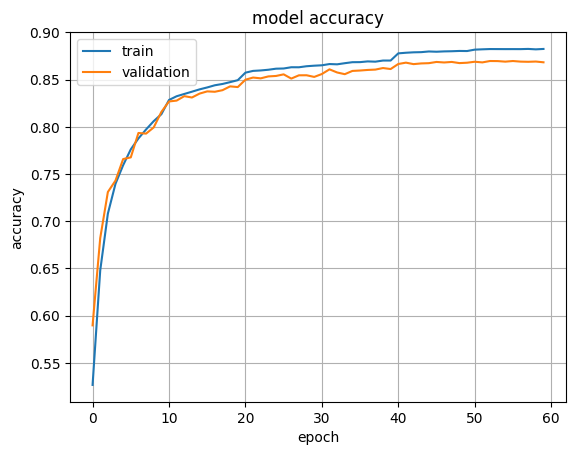

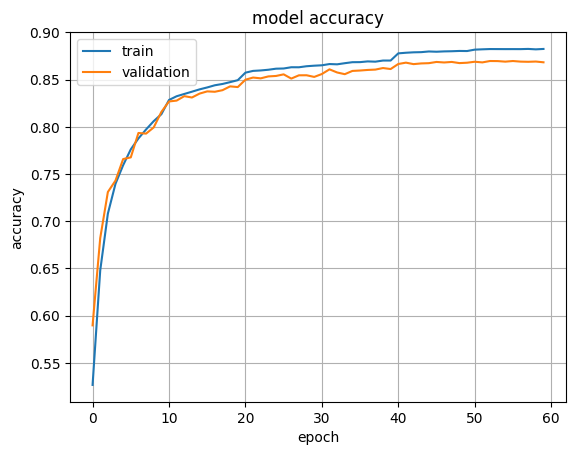

In [25]:
histories = utils.merge_histories(histories)

utils.plot_accuracy(utils.slice_history(histories))

**First try**: with parallel layers TODO

**Second try**: Two parallel convolutional and later max pooling layers, with filter sizes 3 and 5, connected to a subsequent second convolutional layer. 

```py
learning_rates = [0.02, 0.01, 0.005, 0.001]
epochs = [10, 10, 20, 10]

batch_size = 32
```

Best result by far yet with 0.8799 accuracy. Seems to confirm that the deeper the better.

![fourth_attempt_11.png](plots/fourth_attempt_11.png)

**Third try**: added one more convolutional and pooling layer, other than that same setup as above. Accuracy 0.8850. 

![fourth_attempt_31.png](plots/fourth_attempt_31.png)

Seems to have significantly less overfitting as well. 



**Fourth try**: Added yet another convolutional layer and the accuracy dropped by about 1% at the same amount of epochs, so going back to the previous architecture. Tried some 10 more epochs with a smaller learning but didn't change much.

![fourth_attempt_41.png](plots/fourth_attempt_41.png)

# TODO: Recursive NN is probably better suited for this

TODO 
occlusion: change some characters randomly?